# Builtinmodels - stepmodel

This example shows how to use `lmfit_global.LmfitGlobal` class to fit data with stepmodel of different kind
. 

This example is similar to `builtinmodels_stepmodel.py` of [lmfit examples](https://lmfit.github.io/lmfit-py/examples/index.html) or [github link](https://github.com/lmfit/lmfit-py/tree/master/examples)


In [1]:
try:
    from lmfit_global import LmfitGlobal
    from lmfit_global.util.utils import GlobalFitBuilder
except (ImportError, ModuleNotFoundError):
    import os, sys
    ROOT = os.path.abspath("..")  # parent of examples
    sys.path.insert(0, ROOT)

    from lmfit_global import LmfitGlobal
    from lmfit_global.util.utils import build_items, GlobalFitBuilder

import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.special import erf
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Args::
        value (float): Value to be ensured not to be zero.

    Returns:
        float: Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def step(x, amplitude=1.0, center=0.0, sigma=1.0, form='linear'):
    """Return a step function.

    Starts at 0.0, ends at `sign(sigma)*amplitude`, has a half-max at
    `center`, rising or falling with `form`:

    - `'linear'` (default) = amplitude * min(1, max(0, arg + 0.5))
    - `'atan'`, `'arctan'` = amplitude * (0.5 + atan(arg)/pi)
    - `'erf'`              = amplitude * (1 + erf(arg))/2.0
    - `'logistic'`         = amplitude * [1 - 1/(1 + exp(arg))]

    where ``arg = (x - center)/sigma``.

    Note that ``sigma > 0`` gives a rising step, while ``sigma < 0`` gives
    a falling step.
    """
    out = np.sign(sigma)*(x - center)/max(tiny*tiny, abs(sigma))

    if form == 'erf':
        out = 0.5*(1 + erf(out))
    elif form == 'logistic':
        out = 1. - 1./(1. + np.exp(out))
    elif form in ('atan', 'arctan'):
        out = 0.5 + np.arctan(out)/np.pi
    elif form == 'linear':
        out = np.minimum(1, np.maximum(0, out + 0.5))
    else:
        msg = (f"Invalid value ('{form}') for argument 'form'; should be one "
               "of 'erf', 'logistic', 'atan', 'arctan', or 'linear'.")
        raise ValueError(msg)

    return amplitude*out


def linear(x, slope=1.0, intercept=0.0):
    """Return a linear function.

    linear(x, slope, intercept) = slope * x + intercept

    """
    return slope * x + intercept


x = np.linspace(0, 10, 201)
y = np.ones_like(x)
y[:48] = 0.0
y[48:77] = np.arange(77-48)/(77.0-48)
np.random.seed(0)
y = 110.2 * (y + 9e-3*np.random.randn(x.size)) + 12.0 + 2.22*x

In [3]:
init_step = {
    'amplitude': {'value':100, 'vary':True, 'min':-np.inf, 'max':+np.inf},
    'center': {'value':2.5, 'min':0, 'max':10},
    'sigma': {'value':1, },
}

init_line = {
    'slope': {'value':0.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
    'intercept': {'value':0, },
}

old fashion way of building items, using `util.utils.build_items()`

INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 1 dataset(s) with N=201 points each...
INFO: XRANGE: N=201 points each for user supplied xrange [0.0, 10.0] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 2 model component(s) detected — multi-component fit...
INFO: The model connectors used: [+]
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: ######################################################################
INFO: # y(x;) = step(x, amplitude, center, sigma, form) + linear(x, slope, #
INFO: # intercept)                                                         #
INFO: ######################################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...
INFO: Fitting started (fit_method='leastsq') ...
IN

[[Model]]
    (Model(step, prefix='c0_') + Model(linear, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 201
    # variables        = 5
    chi-square         = 593.709621
    reduced chi-square = 3.02913072
    Akaike info crit   = 227.700173
    Bayesian info crit = 244.216698
    R-squared          = 0.99897798
[[Variables]]
    c0_amplitude_0:  112.858622 +/- 0.65391460 (0.58%) (init = 100)
    c0_center_0:     3.13494787 +/- 0.00516600 (0.16%) (init = 2.5)
    c0_sigma_0:      0.67393574 +/- 0.01091151 (1.62%) (init = 1)
    c1_slope_0:      1.87161866 +/- 0.09318566 (4.98%) (init = 0)
    c1_intercept_0:  12.0964537 +/- 0.27605985 (2.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0_amplitude_0, c1_slope_0)     = -0.8791
    C(c0_amplitude_0, c0_sigma_0)     = +0.5643
    C(c0_sigma_0, c1_slope_0)         = -0.4569
    C(c0_center_0, c1_intercept_0)    = +0.4269
    C(c1_slope_0,

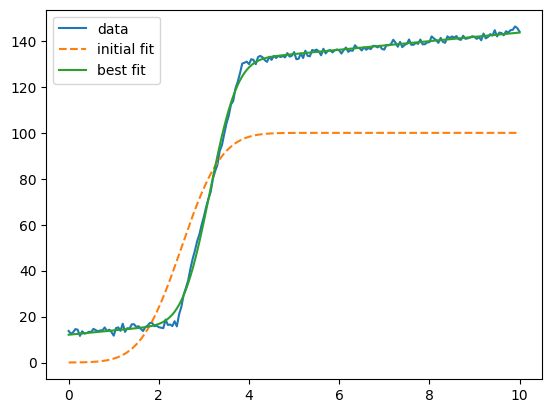

In [4]:
xy = np.column_stack([x, y])

items = build_items(
    xy=xy,
    functions=[
        {
            "func_name": step,
            "init_params": init_step,
            "func_kws": {'form': 'erf'},
        },
        {
            "func_name": linear,
            "init_params": init_line,
        },
    ],
    connectors=["+"],
)


lg = LmfitGlobal(items)
lg.fit()
lg.report()

plt.figure()
plt.plot(x, y, label='data')
plt.plot(x, lg.init_fit, '--', label='initial fit')
plt.plot(x, lg.best_fit, '-', label='best fit')
plt.legend()
plt.show()

or simply with `GlobalFitBuilder()` class

INFO: Parsing inputs...
INFO: Parsing input data...
INFO: Detected 1 dataset(s) with N=201 points each...
INFO: XRANGE: N=201 points each for user supplied xrange [0.0, 10.0] ...
INFO: Parsing input data COMPLETED...
INFO: Parsing function models...
INFO: 2 model component(s) detected — multi-component fit...
INFO: The model connectors used: [+]
INFO: Parsing function models COMPLETED...
INFO: The model is to be constructed as...
INFO: ######################################################################
INFO: # y(x;) = step(x, amplitude, center, sigma, form) + linear(x, slope, #
INFO: # intercept)                                                         #
INFO: ######################################################################
INFO: Building lmfit backend...
INFO: Creating lmfit.Models for the models(s) function(s)...
INFO: Building lmfit CompositeModel...
INFO: CompositeModel built successfully...
INFO: Initialized parameters...
INFO: Fitting started (fit_method='leastsq') ...
IN

[INFO] step: missing init parameters ['form'].
[[Model]]
    (Model(step, prefix='c0_') + Model(linear, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 201
    # variables        = 5
    chi-square         = 593.709621
    reduced chi-square = 3.02913072
    Akaike info crit   = 227.700173
    Bayesian info crit = 244.216698
    R-squared          = 0.99897798
[[Variables]]
    c0_amplitude_0:  112.858622 +/- 0.65391460 (0.58%) (init = 100)
    c0_center_0:     3.13494787 +/- 0.00516600 (0.16%) (init = 2.5)
    c0_sigma_0:      0.67393574 +/- 0.01091151 (1.62%) (init = 1)
    c1_slope_0:      1.87161866 +/- 0.09318566 (4.98%) (init = 0)
    c1_intercept_0:  12.0964537 +/- 0.27605985 (2.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(c0_amplitude_0, c1_slope_0)     = -0.8791
    C(c0_amplitude_0, c0_sigma_0)     = +0.5643
    C(c0_sigma_0, c1_slope_0)         = -0.4569
    C(c0_center_0,

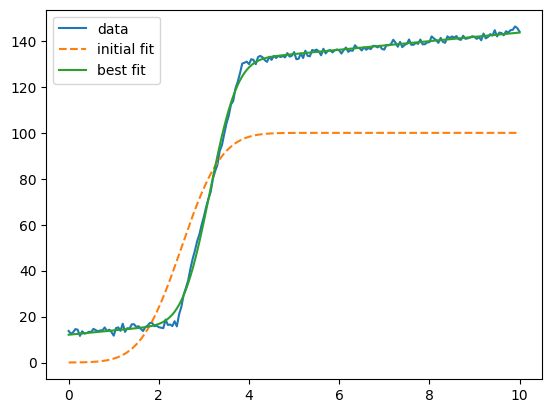

In [5]:
builder = (
    GlobalFitBuilder()
    .set_data(x, y)                      # x and all y datasets
    .add_model(step,   init_step, func_kws={'form': 'erf'})  # CHOICES: 'erf', 'logistic', 'atan', 'arctan', or 'linear'
    .add_model(linear, init_line, func_kws={})       
    .connect("+")                             # how to combine the 2 functions
)
# Above: you can test different form of step functions

items = builder.build()

lg = LmfitGlobal(items)
lg.fit()
lg.report()

plt.figure()
plt.plot(x, y, label='data')
plt.plot(x, lg.init_fit, '--', label='initial fit')
plt.plot(x, lg.best_fit, '-', label='best fit')
plt.legend()
plt.show()